In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import xarray as xr
import sys,os,glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(0,'../../../')

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200

# Quickstart 

## Step 1: initialize Twind class

We are initilizing the :class:`.TigressWindModel` class with default parameters set to match the TIGRESS simulation suite results at $|z|=H$ (see :ref:`simulation_pdfs`). Possible options are `z0=['H', '2H', '500', '1000']`. 

In [3]:
import twind

tw=twind.TigressWindModel(z0='H',verbose=True)

number of wind phase = 2
galactic parameter = sfr
reference height = H
cool_params
    A_v = 2.302585092994046
    p_v = 1
    d_v = 2
    A_cs = 9.185985478173896
    cs0 = 6.7
    sigma = 0.1
    vout0 = 25.0
hot_params
    A_vB = 5.196378098798331
    p_vB = 4
    d_vB = 2
    A_M = 1.151292546497023
    Mach0 = 0.5
    p_M = 1
    d_M = 3
params
    Esn = 1e+51 erg
    mstar = 95.5 solMass
    vcool = 200.0 km / s
    Mej = 10.0 solMass
    ZSN = 0.2
    ZISM0 = 0.02
    vej = 3171.4804794827423 km / s
ref_params
    Mref = 95.5 solMass
    pref = 2.5e+48 erg s / km
    Eref = 1e+51 erg
    Zref = 2.0 solMass
scaling_params
    a = [-0.067 -1.216 -0.857  0.013 -1.426 -2.151 -1.013 -0.879 -2.228 -2.627
 -0.698 -0.695  0.171 -0.942 -0.375  0.281]
    b = [-0.441 -0.227 -0.069 -0.418 -0.287 -0.149  0.016 -0.157 -0.117 -0.076
  0.136  0.108 -0.364 -0.146  0.04  -0.335]
    A = [0.86 0.06 0.14 1.03 0.04 0.01 0.1  0.13 0.01 0.   0.2  0.2  1.48 0.11
 0.42 1.91]
    p = [0.559 0.773 0.931 

With the `verbose=True` option, key attributes are printed.

- `cool_params`: parameters for cool mass loading PDF. See :ref:`model`    
- `hot_params`: parameters for hot mass loading PDF. See :ref:`model`    
- `params`: other physical parameters related to the particular choices of the TIGRESS simulation suite (see [Kim et al. (2020a)](https://ui.adsabs.harvard.edu/abs/2020arXiv200616315K/abstract))
- `ref_params`: outflow rates are normalized by $\Sigma_{\rm SFR}q_{\rm ref}/m_*$ to obtain loading factors
- `scaling_params`: fitting results for velocity-integrated loading factors as a function of SFR surface density (in log-log space) presented in [Kim et al. (2020a)](https://ui.adsabs.harvard.edu/abs/2020arXiv200616315K/abstract). Each array contains the results for four loading factors (mass, momentum, energy, metal) of four phases (cool, intermediate, hot, whole). E.g., first four values are the results for the mass loading factor of cool, intermediate, hot, and whole gas.
  - `a` is the intercept
  - `b` is the slope
  - `A` is $10^a$
  - `p` is $b+1$ for flux scalings.
  
$$ \eta_q = A\Sigma_{\rm SFR}^b $$

## Step 2: setup axes

We use [xarray](http://xarray.pydata.org/en/stable/) extensibly for easier manipulation with broadcasting, indexing, slicing, and interpolation.

The :meth:`.TigressWindModel.set_axes` method accept either the simulated PDF (in the form of `xarray.Dataset`) or list of ranges (in log) and number of bins for `vout` and `cs` axes (`sfr` can either be a scalar or an array).
Default is 

- `vout` = (0,4,500)
- `cs` = (0,4,500)
- `sfr` = (-6,2,100)

This function will set attributes `u=logvout` and `w=logcs` as 1D `DataArray` as well as `vBz` and `Mach` as 2D `DataArray` for future use. If a range of `sfr` is passed, it will also set a member `logsfr` as 1D `DataArray` with different coordinates so that the final PDFs would be 3D `DataArray`.

For this example, we use a single value of SFR surface density and reduced number of bins for velocity axes.

In [4]:
tw.set_axes(vout=(0,4,200),cs=(0,4,200),sfr=0.01,verbose=True)

sfr=0.01
cs: min=0, max=4, N=200
vout: min=0, max=4, N=200


We make sure that `vBz` and `Mach` are 2D while `u=logvout` and `w=logcs` are 1D. 

u shpae: (200,)
w shape: (200,)
vBz shpae: (200, 200)
Mach shape: (200, 200)


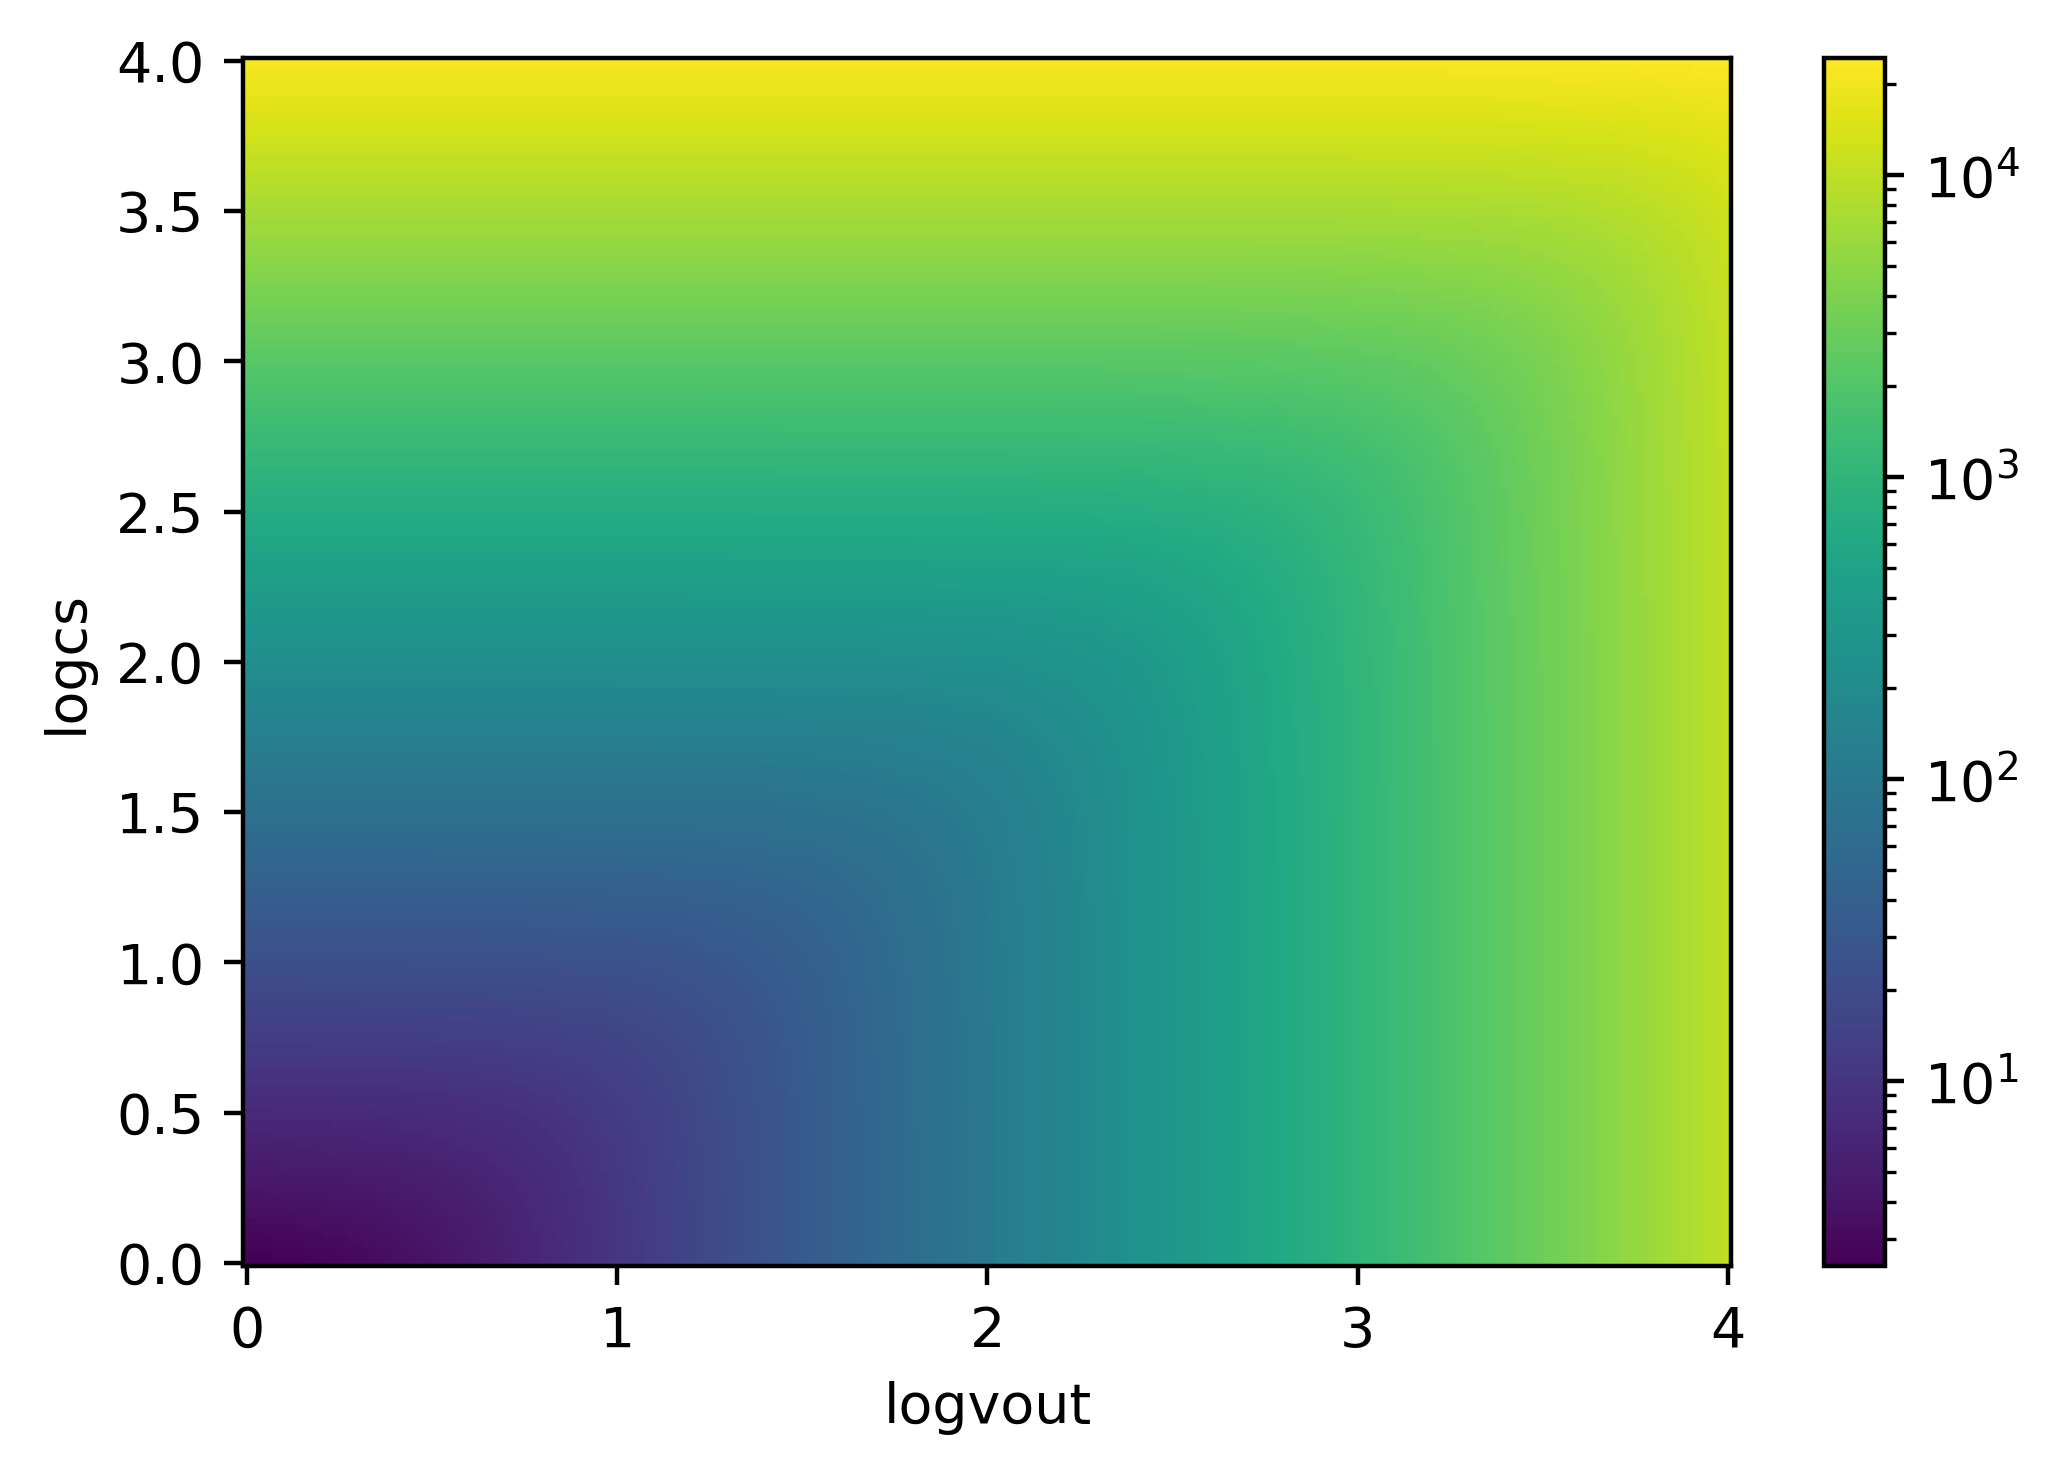

In [5]:
print('u shpae:',tw.u.shape)
print('w shape:',tw.w.shape)
print('vBz shpae:',tw.vBz.shape)
print('Mach shape:',tw.Mach.shape)
g=tw.vBz.plot(norm=LogNorm())

## Step 3: build mass loading PDFs

We have a method :meth:`.TigressWindModel.build_Mpdf` that automatically builds model PDFs for mass loading factor and return a `xarray.Dataset`. Note that if the range of `(u,w)` is not large enough, the mass PDF may not integrate to 1 (use `verbose=True` to check this).

Depending on the choice of the `sfr` axis, the resulting PDF can either be 2D or 3D. The returned `Dataset` have variables for PDFs (`Mpdf`, `Mpdf-cool`, `Mpdf-hot`) for `total`, `cool`, and `hot` outflow components. This also contains `vBz` and `Mach` as 2D arrays for convenience. In addition, the integrated loading factor (`etaM` and their phase-separated values, i.e., `etaM-cool` and `etaM-hot`) as a function of `sfr` are saved. If `sfr` is a scalar, these are also scalars.


In [6]:
pdf = tw.build_Mpdf(verbose=True)

Mass PDFs are integrated to: cool=0.997 hot=1


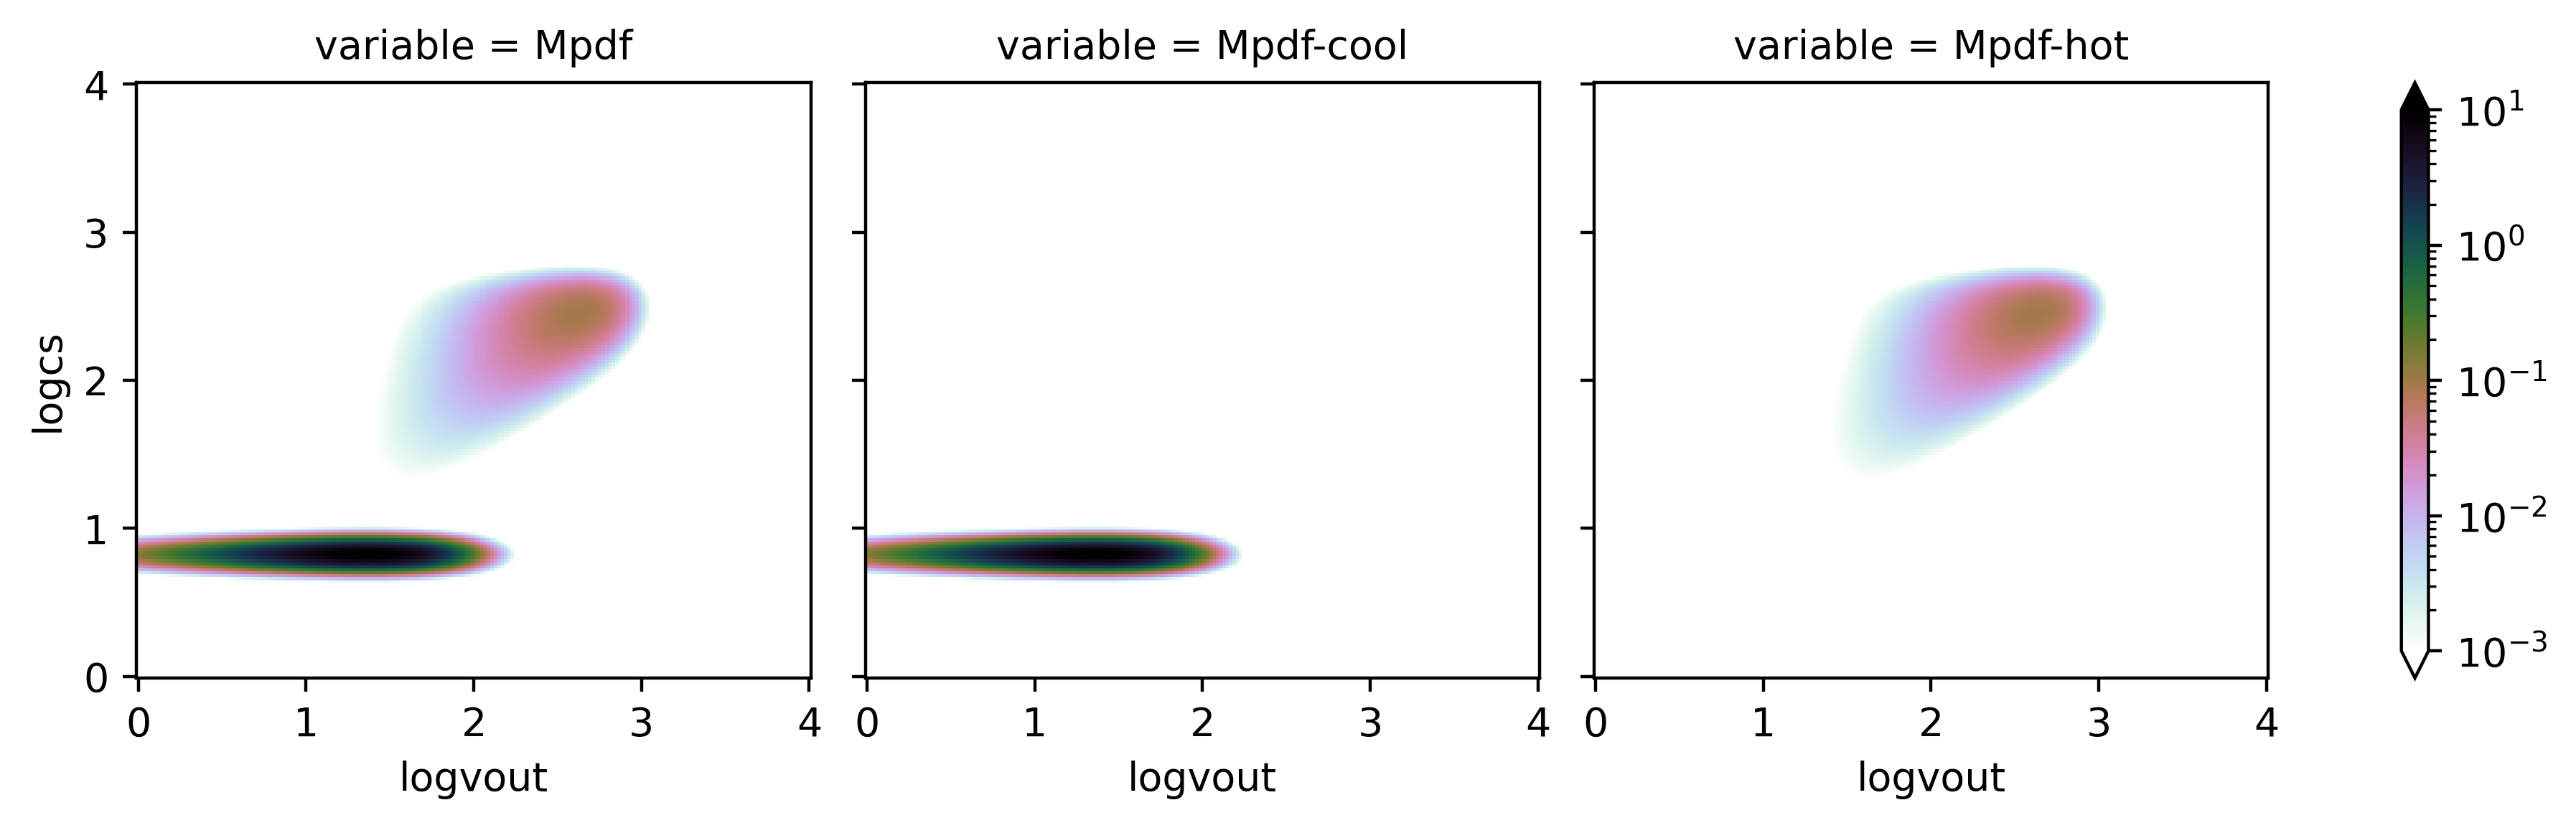

In [7]:
pdf[['Mpdf','Mpdf-cool','Mpdf-hot']].to_array().plot(col='variable',
                                                   norm=LogNorm(vmin=1.e-3,vmax=10),
                                                   cmap=plt.cm.cubehelix_r
                                                  )

## Step 4: build all PDFs

We have a method :meth:`.TigressWindModel.build_model` that automatically builds model PDFs for mass, momentum, energy, and metal loading factors and return a `xarray.Dataset` containing all. The last three PDFs are reconstructed from the mass PDF as outlined in [Kim et al. (2020b)](link). By default, they are renormalized to ensure the integration over the entire `(u,w)` gives 1. Note that the metal PDF is not normalized for the input `ZISM` but for `ZISM0`.

Again, depending on the choice of the `sfr` axis, the resulting PDFs can either be 2D or 3D. The returned `Dataset` have variables for PDFs (`Mpdf`, `ppdf`, `Epdf`, `Zpdf`) and their phase-separated counterparts (e.g., `Mpdf-cool`, `Mpdf-hot`). The velocity-integrated loading factors (`etaM`, `etap`, `etaE`, `etaZ`) and their phase-separated counterparts (e.g., `etaM-cool` and `etaM-hot`) as a function of `sfr` are also stored. Finally, if `renormalize=True` (default), it also stores the renormalization factors (`p_renorm`, `E_renorm`, `Z_renorm`), which are also a function of `sfr`. 

The `Dataset` has attributes for the choice of `ZISM` for the metal loading PDF as well as the bin sizes `dlogcs` and `dlogvout` for convenience.

In [8]:
pdf=tw.build_model(renormalize=True,energy_bias=True)

As it builds a model PDF, it automatically checks whether the mass PDFs are integrated to 1. I.e., both cool and hot PDFs should satisfy 

$$\int\int \tilde{f}_M^{\rm ph} dudw =1 $$

individually. Again, this may depend on the `(u,w)` range. We then apply loading factor ratios to combine the mass loading PDF as

$$\tilde{f}_M = \frac{\eta_M^{\rm cool}}{\eta_M}\tilde{f}_M^{\rm cool}+\frac{\eta_M^{\rm hot}}{\eta_M}\tilde{f}_M^{\rm hot}$$

Note that `Mpdf-cool` and `Mpdf-hot` (and corresponding other PDFs) in the returned `Dataset` are not $\tilde{f}_M^{\rm ph}$ but $\frac{\eta_M^{\rm ph}}{\eta_M}\tilde{f}_M^{\rm ph}$.

In [9]:
dudw=pdf.attrs['dlogvout']*pdf.attrs['dlogcs']
print('contribution to')
print('mass outflow rate from cool is {:.3f} and hot is {:.3f}'.format(
    pdf['Mpdf-cool'].sum().data*dudw,pdf['Mpdf-hot'].sum().data*dudw))
print('energy outflow rate from cool is {:.3f} and hot is {:.3f}'.format(
    pdf['Epdf-cool'].sum().data*dudw,pdf['Epdf-hot'].sum().data*dudw))

contribution to
mass outflow rate from cool is 0.968 and hot is 0.029
energy outflow rate from cool is 0.081 and hot is 0.919


Finally, 2D PDFs for mass, momentum, energy, and metal loadings at $\Sigma_{\rm SFR}=10^{-2}$ look as follows.

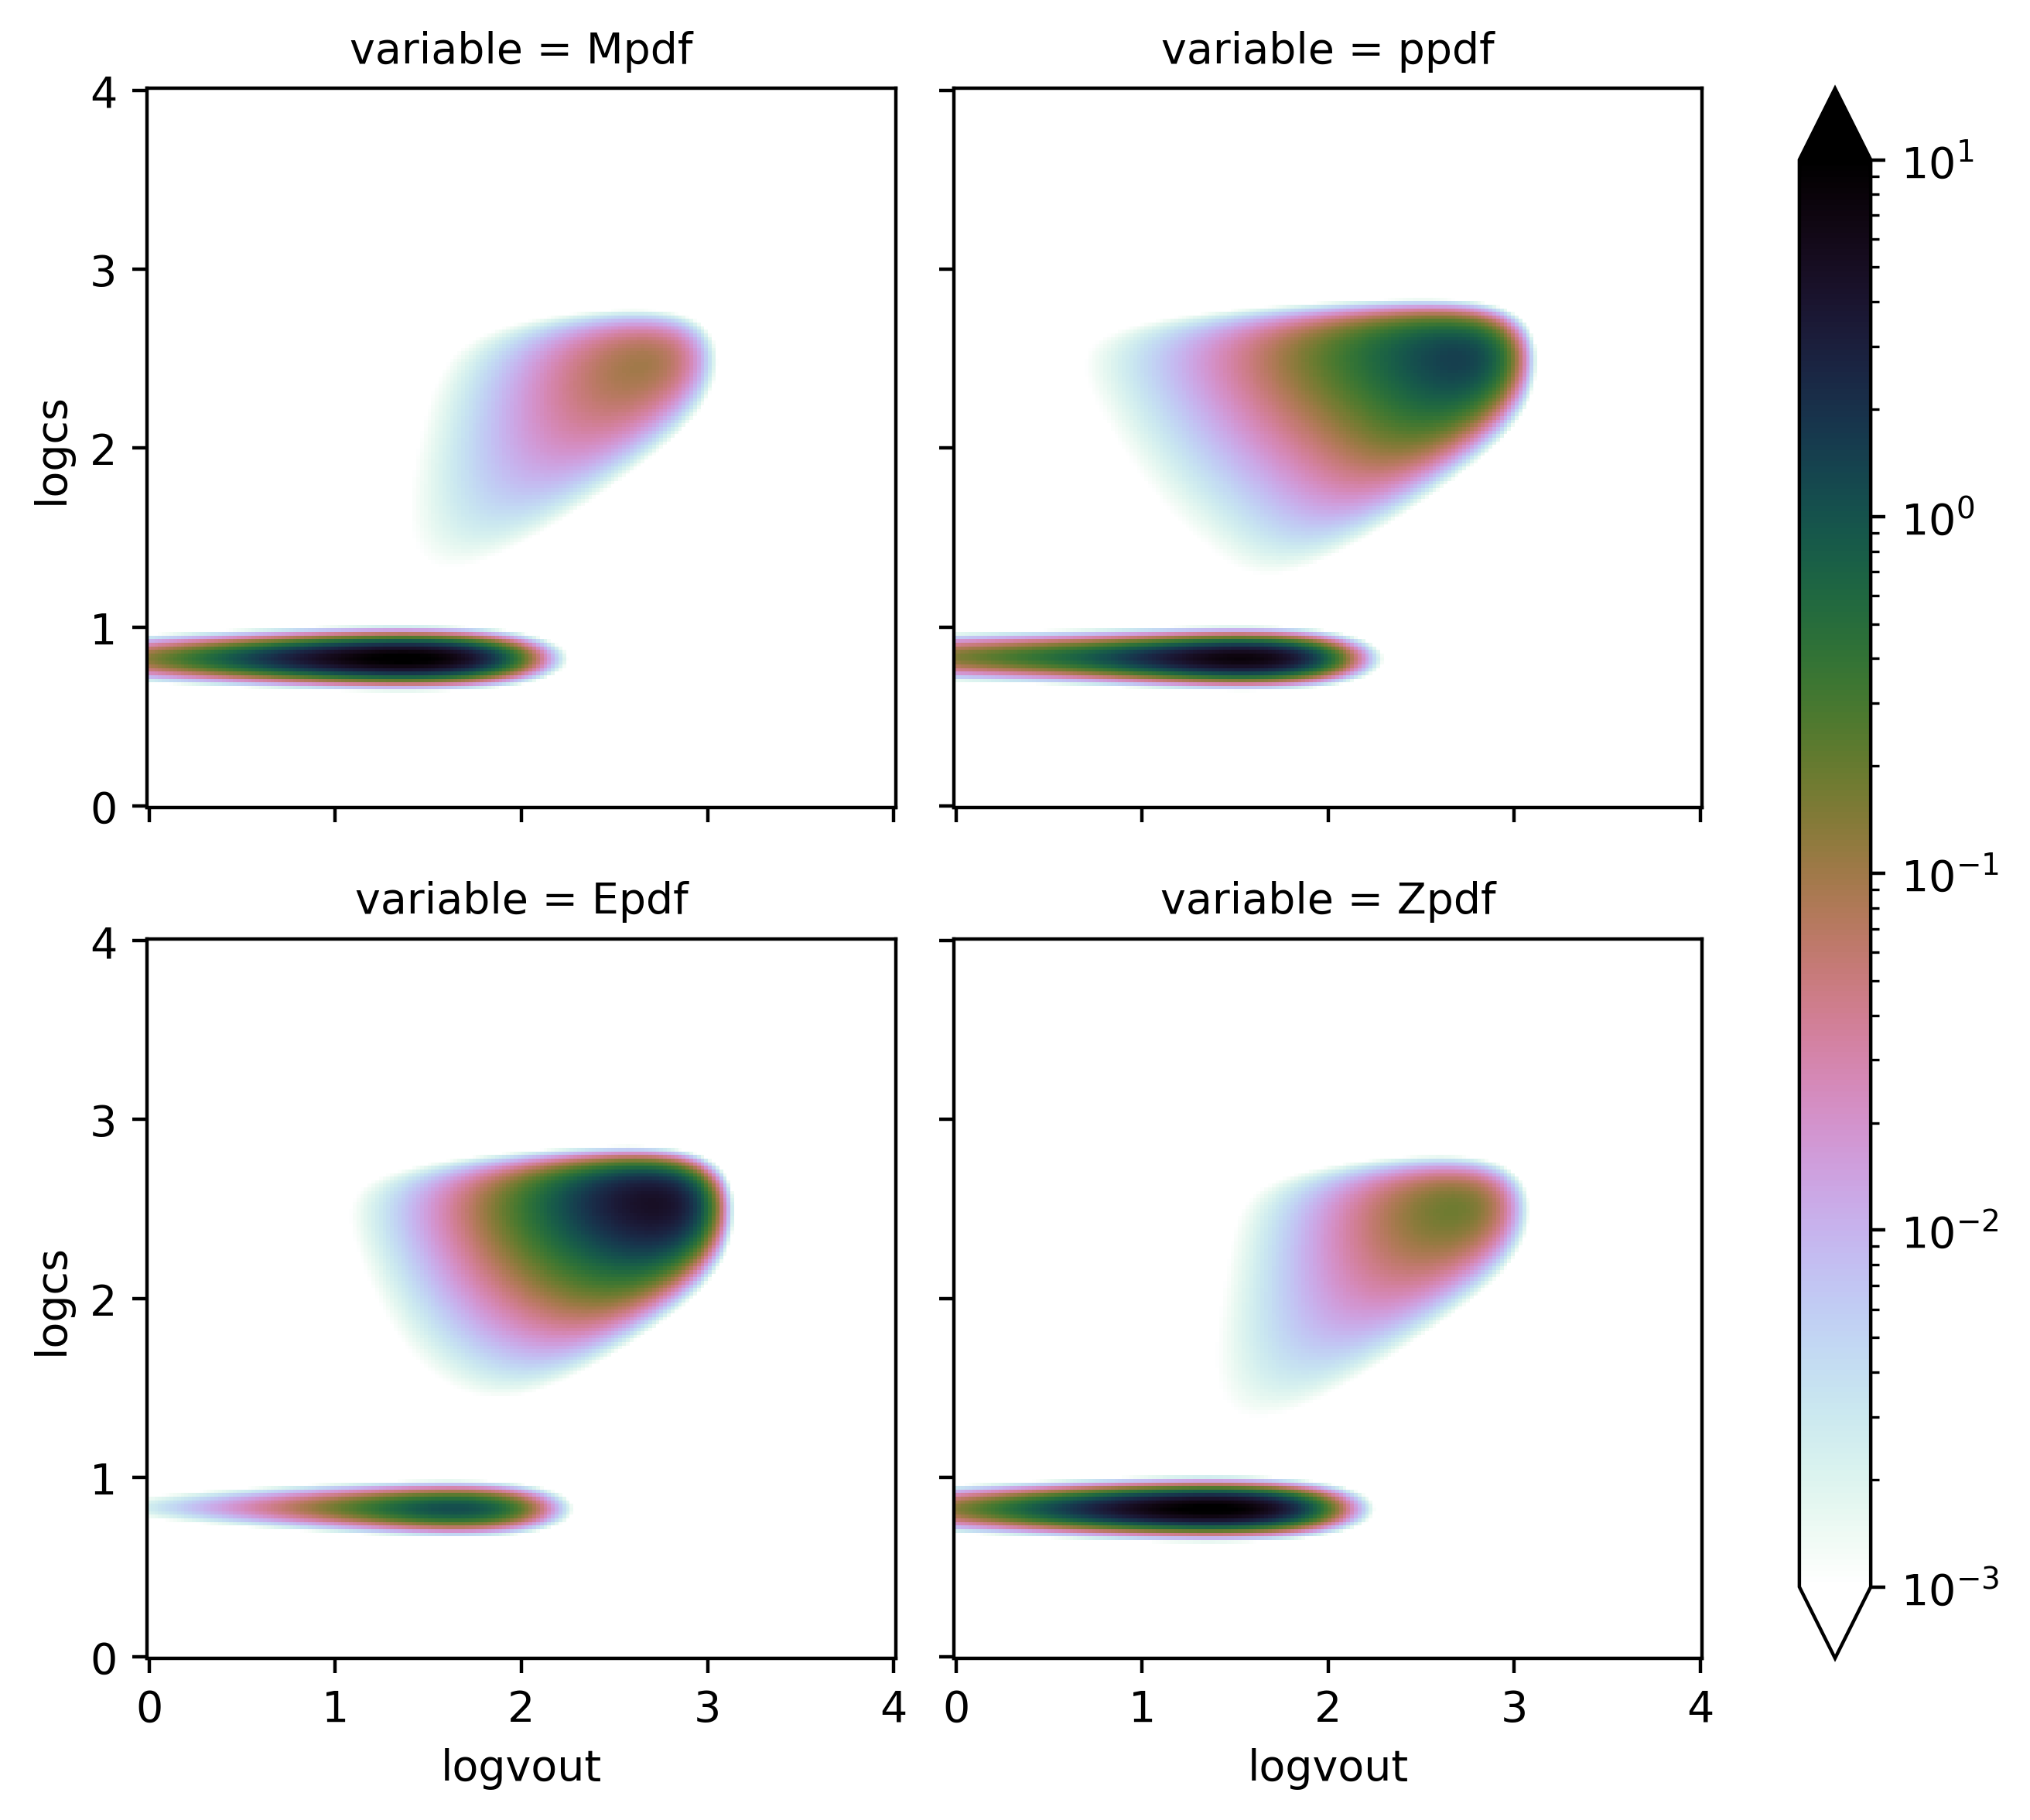

In [10]:
pdf[['Mpdf','ppdf','Epdf','Zpdf']].to_array().plot(col='variable',col_wrap=2,
                                                   norm=LogNorm(vmin=1.e-3,vmax=10),
                                                   cmap=plt.cm.cubehelix_r
                                                  )